In [1]:
!git clone --branch develop --single-branch https://github.com/sonyaaat/big-data-2025.git

Cloning into 'big-data-2025'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 188 (delta 2), reused 1 (delta 1), pack-reused 169 (from 1)
Receiving objects: 100% (188/188), 96.59 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [2]:
!ls

big-data-2025  sample_data


In [4]:
!python /content/download_dataset.py

All downloads complete! Extracting files...
Extracting name.basics.tsv.gz...
Extracting title.akas.tsv.gz...
Extracting title.basics.tsv.gz...
Extracting title.crew.tsv.gz...
Extracting title.episode.tsv.gz...
Extracting title.principals.tsv.gz...
Extracting title.ratings.tsv.gz...
Extraction complete!
Downloaded and extracted files:
['title.principals.tsv', 'title.episode.tsv', 'title.basics.tsv', 'title.akas.tsv', 'name.basics.tsv', 'title.ratings.tsv', 'title.crew.tsv']


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import col, desc, first, count, avg, when, array_contains, dense_rank
import os
from pyspark.sql import DataFrame
from typing import Dict
from config import Config

from schemas import (
    schema_title_basics,
    schema_title_episode,
    schema_title_crew,
    schema_title_akas,
    schema_title_ratings,
    schema_title_principals,
    schema_name_basics
)

from imdb_spark_utils import (
    initialize_spark,
    load_dataframe,
    transform_title_basics,
    transform_title_akas,
    transform_title_crew,
    transform_title_episode,
    display_dataframe_info,
    transform_title_ratings,
    transform_title_principals,
    transform_name_basics
)

spark_session = initialize_spark("IMDB Data Processing")


def check_pyspark() -> None:
    print("Initializing Spark Session...")
    spark = SparkSession.builder \
        .appName("IMDB Data Check") \
        .getOrCreate()

    print("Spark Session initialized.")
    print("Checking available files...")
    files = [f for f in os.listdir(Config.DATA_DIR) if f.endswith(Config.FILE_EXTENSION)]

    if not files:
        print("No TSV files found. Make sure data is downloaded and extracted.")
        return

    print("Found files:", files)

    sample_file = os.path.join(Config.DATA_DIR, files[0])
    print(f"Loading sample file: {sample_file}")

    df = spark.read.option("header", "true").option("sep", "\t").csv(sample_file)

    print("Schema of the loaded file:")
    df.printSchema()

    print("Showing first 5 rows:")
    df.show(5)

    print("PySpark check complete!")

    spark.stop()


def process_imdb_data() -> Dict[str, DataFrame]:
    dataframes = {}

    dataframes["basics"] = transform_title_basics(
        load_dataframe(spark_session, schema_title_basics, f"{Config.DATA_DIR}/title.basics{Config.FILE_EXTENSION}")
    )
    dataframes["akas"] = transform_title_akas(
        load_dataframe(spark_session, schema_title_akas, f"{Config.DATA_DIR}/title.akas{Config.FILE_EXTENSION}")
    )
    dataframes["crew"] = transform_title_crew(
        load_dataframe(spark_session, schema_title_crew, f"{Config.DATA_DIR}/title.crew{Config.FILE_EXTENSION}")
    )
    dataframes["episode"] = transform_title_episode(
        load_dataframe(spark_session, schema_title_episode, f"{Config.DATA_DIR}/title.episode{Config.FILE_EXTENSION}")
    )
    dataframes["ratings"] = transform_title_ratings(
        load_dataframe(spark_session, schema_title_ratings, f"{Config.DATA_DIR}/title.ratings{Config.FILE_EXTENSION}")
    )
    dataframes["principals"] = transform_title_principals(
        load_dataframe(spark_session, schema_title_principals, f"{Config.DATA_DIR}/title.principals{Config.FILE_EXTENSION}")
    )
    dataframes["name"] = transform_name_basics(
        load_dataframe(spark_session, schema_name_basics, f"{Config.DATA_DIR}/name.basics{Config.FILE_EXTENSION}")
    )

    for name, df in dataframes.items():
        display_dataframe_info(df, name)

    return dataframes


dataframes = process_imdb_data()


=== basics ===
First 5 rows:
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+----------------------------+
|tconst   |titleType|primaryTitle          |originalTitle         |isAdult|startYear|endYear|runtimeMinutes|genres                      |
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+----------------------------+
|tt0000001|short    |Carmencita            |Carmencita            |NULL   |1894     |NULL   |1             |[Documentary, Short]        |
|tt0000002|short    |Le clown et ses chiens|Le clown et ses chiens|NULL   |1892     |NULL   |5             |[Animation, Short]          |
|tt0000003|short    |Poor Pierrot          |Pauvre Pierrot        |NULL   |1892     |NULL   |5             |[Animation, Comedy, Romance]|
|tt0000004|short    |Un bon bock           |Un bon bock           |NULL   |1892     |NULL   |12            |[Animation, Short]          |
|tt0

In [ ]:
def export_result(df: DataFrame, result_path: str, show_rows: int = 20, title: str = None,
                  partition_column: str = None, num_partitions: int = None) -> None:
    print(f"Results for: {title}")
    df.show(show_rows, truncate=False)
    total_records = df.count()
    print(f"Total number of records in the result: {total_records}")

    #for col_name, col_type in df.dtypes:
    #    if col_type.startswith("array"):
    #        df = df.withColumn(col_name, F.concat_ws(", ", F.col(col_name)))

    #writer = df.write.option("header", "true")

    #if partition_column and partition_column in df.columns:
    #    print(f"Exporting results with partitioning by column: {partition_column}")
    #    writer.partitionBy(partition_column).csv(result_path, mode="overwrite")
    #elif num_partitions and num_partitions > 0:
   #     print(f"Exporting results with {num_partitions} partitions")
   #     df.repartition(num_partitions).write.option("header", "true").csv(result_path, mode="overwrite")
    #else:
    #    target_size_mb = 128
    #    estimated_size_bytes = total_records * len(df.columns) * 100
    #    estimated_size_mb = estimated_size_bytes / (1024 * 1024)
    #    optimal_partitions = max(1, int(estimated_size_mb / target_size_mb))

    #    print(f"Exporting results with automatically determined {optimal_partitions} partitions")
    #    df.repartition(optimal_partitions).write.option("header", "true").csv(result_path, mode="overwrite")


def most_popular_genres_by_region(
        movie_basics: DataFrame,
        akas: DataFrame,
        ratings: DataFrame,
        results_dir: str,
        min_votes: int = 1000) -> None:

    filtered_basics = movie_basics.filter(
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    basics_with_ratings = filtered_basics.join(
        ratings.filter(F.col("numVotes") >= min_votes),
        "tconst",
        "inner"
    )

    region_data = akas.filter(F.col("region").isNotNull())

    pre_join_df = basics_with_ratings.join(
        region_data,
        basics_with_ratings.tconst == region_data.titleId,
        "inner"
    ).drop(region_data.titleId)

    exploded_df = pre_join_df.withColumn("genre", F.explode("genres"))

    filtered_df = exploded_df.filter(F.col("genre").isNotNull())

    filtered_df = filtered_df.persist()

    agg_df = filtered_df.groupBy("region", "genre").agg(
        F.countDistinct(filtered_basics.tconst).alias("title_count"),
        F.avg("averageRating").alias("avg_rating")
    )

    window_spec = Window.partitionBy("region").orderBy(F.desc("title_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("region", "rank")

    filtered_df.unpersist()

    export_result(ranked_df, os.path.join(results_dir, "most_popular_genres_by_region"), title="most_popular_genres_by_region")


def yearly_genre_trend_analysis(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str,
        min_votes: int = 1000) -> None:

    filtered_basics = movie_basics.filter(
        F.col("startYear").isNotNull() &
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    filtered_ratings = ratings.filter(
        F.col("averageRating").isNotNull() &
        (F.col("numVotes") >= min_votes)
    ).select("tconst", "averageRating", "numVotes")

    join_df = filtered_basics.join(filtered_ratings, "tconst", "inner")
    join_df = join_df.persist()

    exploded_df = join_df.withColumn("genre", F.explode("genres"))

    agg_df = exploded_df.groupBy("startYear", "genre").agg(
        F.count("*").alias("movie_count"),
        F.avg("averageRating").alias("avg_rating"),
        F.avg("numVotes").alias("avg_votes")
    )

    window_spec = Window.partitionBy("startYear").orderBy(F.desc("movie_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy(F.desc("startYear"), "rank")

    join_df.unpersist()

    export_result(ranked_df, os.path.join(results_dir, "yearly_genre_trend_analysis"), title='yearly_genre_trend_analysis')


def most_successful_directors(
        movie_basics: DataFrame,
        crew: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10) -> None:

    directors_df = (crew.filter(F.col("directors").isNotNull())
                    .join(movie_basics.select("tconst"), "tconst", "inner")
                    .withColumn("director_id", F.explode("directors"))
                    .join(ratings, "tconst", "inner")
                    .filter((F.col("numVotes") >= min_votes) & F.col("averageRating").isNotNull())
                    .join(name_df.select("nconst", "primaryName"),
                          F.col("director_id") == F.col("nconst"), "inner")
                    .select("tconst", F.col("primaryName").alias("director"), "averageRating", "numVotes"))

    directors_agg = (directors_df.groupBy("director")
                     .agg(
                         F.count("*").alias("movie_count"),
                         F.avg("averageRating").alias("avg_rating")
                     )
                     .filter(F.col("movie_count") >= min_movies))

    window_spec_dir = Window.orderBy(F.desc("avg_rating"))

    directors_ranked = (directors_agg.withColumn("rank", F.dense_rank().over(window_spec_dir))
                        .withColumn("role", F.lit("director"))
                        .orderBy("rank"))

    export_result(directors_ranked, os.path.join(results_dir, "most_successful_directors"), title='most_successful_directors')


def top_actors_by_genre(
        movie_basics: DataFrame,
        principals: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10,
        high_rating_threshold: float = 7) -> None:

    movies_with_ratings = (movie_basics.join(ratings, "tconst", "inner")
                           .filter(
                               F.col("startYear").isNotNull() &
                               F.col("averageRating").isNotNull() &
                               F.col("genres").isNotNull() &
                               (F.col("numVotes") >= min_votes)
                           )
                           .withColumn("genre", F.explode("genres"))
                           )

    actors_df = (principals.filter(F.col("category").isin("actor", "actress"))
                 .join(movies_with_ratings, "tconst", "inner"))

    actors_with_name = actors_df.join(name_df, "nconst", "inner")

    high_rated_movies = actors_with_name.filter(F.col("averageRating") >= high_rating_threshold)

    actor_movie_count = (actors_with_name.groupBy("primaryName")
                         .agg(F.count("*").alias("movie_count"))
                         .filter(F.col("movie_count") >= min_movies))

    high_rated_movies_filtered = high_rated_movies.join(actor_movie_count, "primaryName", "inner")

    agg_df = high_rated_movies_filtered.groupBy("genre", "primaryName").agg(
        F.count("*").alias("high_rated_movie_count")
    )

    window_spec = Window.partitionBy("genre").orderBy(F.desc("high_rated_movie_count"))

    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("genre", "rank")

    export_result(ranked_df, os.path.join(results_dir, "top_actors_by_genre"), title='top_actors_by_genre')


def most_successful_genre_combinations(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str,
        min_votes: int = 1000) -> None:

    basics_filtered = movie_basics.filter(F.col("genres").isNotNull() & (F.size("genres") > 1))

    basics_sorted = (basics_filtered
                     .withColumn("sorted_genres", F.array_sort("genres"))
                     .withColumn("genre_combo", F.concat_ws(", ", F.col("sorted_genres"))))

    joined = (basics_sorted
              .join(ratings, "tconst", "inner")
              .filter((F.col("averageRating").isNotNull()) & (F.col("numVotes") >= min_votes)))

    agg_df = (joined.groupBy("genre_combo")
              .agg(
                  F.count("*").alias("movie_count"),
                  F.avg("averageRating").alias("avg_rating"),
                  F.max("startYear").alias("latest_year")
              )
              .orderBy(F.desc("latest_year"), F.desc("movie_count"), F.desc("avg_rating")))

    export_result(agg_df, os.path.join(results_dir, "most_successful_genre_combinations"), title='most_successful_genre_combinations')


def top_directors_by_genre(movie_basics: DataFrame, principals: DataFrame, name_basics: DataFrame, ratings: DataFrame, results_dir: str, min_votes: int = 1000) -> None:

    movies = movie_basics.filter(
        (F.col("titleType") == "movie") & F.col("genres").isNotNull()
    ).select("tconst", "genres")

    movies_with_ratings = movies.join(ratings, "tconst", "inner") \
                                .filter(F.col("numVotes") >= min_votes) \
                                .select("tconst", "genres", "averageRating")

    directors = principals.filter(F.col("category") == "director") \
                          .select("tconst", "nconst")

    movies_with_directors = movies_with_ratings.join(
        directors, "tconst", "inner"
    ).join(
        name_basics.withColumnRenamed("primaryName", "director_name"),
        "nconst",
        "inner"
    ).select(
        "tconst", "genres", "director_name", "averageRating"
    )

    exploded_genres = movies_with_directors.withColumn("genre", F.explode(F.col("genres")))

    director_genre_stats = exploded_genres.groupBy("genre", "director_name").agg(
        F.avg("averageRating").alias("avg_rating"),
        F.count("*").alias("movie_count")
    ).filter(F.col("movie_count") >= 10)

    window_spec = Window.partitionBy("genre").orderBy(F.desc("avg_rating"), F.desc("movie_count"))
    ranked_directors = director_genre_stats.withColumn("rank", F.row_number().over(window_spec))

    top_directors_by_genre = ranked_directors.filter(F.col("rank") <= 5).orderBy("genre", "rank")

    export_result(top_directors_by_genre, os.path.join(results_dir, "top_directors_by_genre"), title='top_directors_by_genre')


def main(dataframes: dict, results_dir: str = "results") -> None:
    os.makedirs(results_dir, exist_ok=True)

    basics = dataframes["basics"]
    akas = dataframes["akas"]
    crew = dataframes["crew"]
    ratings = dataframes["ratings"]
    principals = dataframes["principals"]
    name_df = dataframes["name"]

    movie_basics = basics.filter(F.col("titleType") == "movie")

    top_directors_by_genre(movie_basics, principals, name_df, ratings, results_dir)
    most_popular_genres_by_region(movie_basics, akas, ratings, results_dir)
    yearly_genre_trend_analysis(movie_basics, ratings, results_dir)
    most_successful_directors(movie_basics, crew, ratings, name_df, results_dir)
    top_actors_by_genre(movie_basics, principals, ratings, name_df, results_dir)
    most_successful_genre_combinations(movie_basics, ratings, results_dir)


main(dataframes, results_dir="results")

Results for: top_directors_by_genre
+---------+-------------------+------------------+-----------+----+
|genre    |director_name      |avg_rating        |movie_count|rank|
+---------+-------------------+------------------+-----------+----+
|Action   |S.S. Rajamouli     |7.558333333333334 |12         |1   |
|Action   |Kenji Misumi       |7.383333333333333 |12         |2   |
|Action   |Mani Ratnam        |7.372727272727274 |11         |3   |
|Action   |Steven Spielberg   |7.245454545454546 |11         |4   |
|Action   |Sherif Arafa       |7.090000000000001 |10         |5   |
|Adventure|Steven Spielberg   |7.319999999999999 |15         |1   |
|Adventure|John Huston        |6.999999999999998 |10         |2   |
|Adventure|Robert Zemeckis    |6.9750000000000005|12         |3   |
|Adventure|Raoul Walsh        |6.809090909090909 |11         |4   |
|Adventure|Ridley Scott       |6.8076923076923075|13         |5   |
|Animation|Hayao Miyazaki     |7.925             |12         |1   |
|Animation|Y

In [ ]:
def export_result(df: DataFrame, result_path: str, show_rows: int = 20, title: str = None,
                  partition_column: str = None, num_partitions: int = None) -> None:
    print(f"Results for: {title}")
    df.show(show_rows, truncate=False)
    total_records = df.count()
    print(f"Total number of records in the result: {total_records}")

    #for col_name, col_type in df.dtypes:
    #    if col_type.startswith("array"):
    #        df = df.withColumn(col_name, F.concat_ws(", ", F.col(col_name)))

    #writer = df.write.option("header", "true")

    #if partition_column and partition_column in df.columns:
    #    print(f"Exporting results with partitioning by column: {partition_column}")
    #    writer.partitionBy(partition_column).csv(result_path, mode="overwrite")
    #elif num_partitions and num_partitions > 0:
   #     print(f"Exporting results with {num_partitions} partitions")
   #     df.repartition(num_partitions).write.option("header", "true").csv(result_path, mode="overwrite")
    #else:
    #    target_size_mb = 128
    #    estimated_size_bytes = total_records * len(df.columns) * 100
    #    estimated_size_mb = estimated_size_bytes / (1024 * 1024)
    #    optimal_partitions = max(1, int(estimated_size_mb / target_size_mb))

    #    print(f"Exporting results with automatically determined {optimal_partitions} partitions")
    #    df.repartition(optimal_partitions).write.option("header", "true").csv(result_path, mode="overwrite")


def most_popular_genres_by_region(
        movie_basics: DataFrame,
        akas: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    filtered_basics = movie_basics.filter(
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    basics_with_ratings = filtered_basics.join(
        ratings,
        "tconst",
        "inner"
    )

    region_data = akas.filter(F.col("region").isNotNull())

    pre_join_df = basics_with_ratings.join(
        region_data,
        basics_with_ratings.tconst == region_data.titleId,
        "inner"
    ).drop(region_data.titleId)

    exploded_df = pre_join_df.withColumn("genre", F.explode("genres"))

    filtered_df = exploded_df.filter(F.col("genre").isNotNull())

    filtered_df = filtered_df.persist()

    agg_df = filtered_df.groupBy("region", "genre").agg(
        F.countDistinct(filtered_basics.tconst).alias("title_count"),
        F.avg("averageRating").alias("avg_rating")
    )

    window_spec = Window.partitionBy("region").orderBy(F.desc("title_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("region", "rank")

    filtered_df.unpersist()

    export_result(ranked_df, os.path.join(results_dir, "most_popular_genres_by_region"))


def yearly_genre_trend_analysis_with_plot(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    # 1. Фільтрація та об'єднання даних
    filtered_basics = movie_basics.filter(
        F.col("startYear").isNotNull() &
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    filtered_ratings = ratings.filter(
        F.col("averageRating").isNotNull() &
        (F.col("numVotes") >= min_votes)
    ).select("tconst", "averageRating", "numVotes")

    join_df = filtered_basics.join(filtered_ratings, "tconst", "inner").persist()

    exploded_df = join_df.withColumn("genre", F.explode("genres"))

    agg_df = exploded_df.groupBy("startYear", "genre").agg(
        F.count("*").alias("movie_count"),
        F.avg("averageRating").alias("avg_rating"),
        F.avg("numVotes").alias("avg_votes")
    )

    window_spec = Window.partitionBy("startYear").orderBy(F.desc("movie_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy(F.desc("startYear"), "rank")

    join_df.unpersist()

    output_path = os.path.join(results_dir, "yearly_genre_trend_analysis.csv")
    ranked_df.toPandas().to_csv(output_path, index=False)

    df = pd.read_csv(output_path)

    top_20_genres = df.groupby("genre")["movie_count"].sum().sort_values(ascending=False).head(20).index
    filtered = df[df["genre"].isin(top_20_genres)]

    plt.figure(figsize=(14, 8))
    for genre in top_20_genres:
        genre_data = filtered[filtered["genre"] == genre].sort_values("startYear")
        plt.plot(genre_data["startYear"], genre_data["movie_count"], label=genre)

    plt.title("Динаміка популярності жанрів за роками (ТОП 20)")
    plt.xlabel("Рік")
    plt.ylabel("Кількість фільмів")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def most_successful_directors(
        movie_basics: DataFrame,
        crew: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10) -> None:

    directors_df = (crew.filter(F.col("directors").isNotNull())
                    .join(movie_basics.select("tconst"), "tconst", "inner")
                    .withColumn("director_id", F.explode("directors"))
                    .join(ratings, "tconst", "inner")
                    .filter((F.col("numVotes") >= min_votes) & F.col("averageRating").isNotNull())
                    .join(name_df.select("nconst", "primaryName"),
                          F.col("director_id") == F.col("nconst"), "left")
                    .select("tconst", F.col("primaryName").alias("director"), "averageRating", "numVotes"))

    directors_agg = (directors_df.groupBy("director")
                     .agg(
                         F.count("*").alias("movie_count"),
                         F.avg("averageRating").alias("avg_rating")
                     )
                     .filter(F.col("movie_count") >= min_movies))

    window_spec_dir = Window.orderBy(F.desc("avg_rating"))

    directors_ranked = (directors_agg.withColumn("rank", F.dense_rank().over(window_spec_dir))
                        .withColumn("role", F.lit("director"))
                        .orderBy("rank"))

    export_result(directors_ranked, os.path.join(results_dir, "most_successful_directors"))


def top_actors_by_genre(
        movie_basics: DataFrame,
        principals: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10,
        high_rating_threshold: float = 7) -> None:

    movies_with_ratings = (movie_basics.join(ratings, "tconst", "inner")
                           .filter(
                               F.col("startYear").isNotNull() &
                               F.col("averageRating").isNotNull() &
                               F.col("genres").isNotNull() &
                               (F.col("numVotes") >= min_votes)
                           )
                           .withColumn("genre", F.explode("genres"))
                           )

    actors_df = (principals.filter(F.col("category").isin("actor", "actress"))
                 .join(movies_with_ratings, "tconst", "inner"))

    actors_with_name = actors_df.join(name_df, "nconst", "inner")

    high_rated_movies = actors_with_name.filter(F.col("averageRating") >= high_rating_threshold)

    actor_movie_count = (actors_with_name.groupBy("primaryName")
                         .agg(F.count("*").alias("movie_count"))
                         .filter(F.col("movie_count") >= min_movies))

    high_rated_movies_filtered = high_rated_movies.join(actor_movie_count, "primaryName", "inner")

    agg_df = high_rated_movies_filtered.groupBy("genre", "primaryName").agg(
        F.count("*").alias("high_rated_movie_count")
    )

    window_spec = Window.partitionBy("genre").orderBy(F.desc("high_rated_movie_count"))

    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("genre", "rank")

    export_result(ranked_df, os.path.join(results_dir, "top_actors_by_genre"))


def most_successful_genre_combinations(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    basics_filtered = movie_basics.filter(F.col("genres").isNotNull() & (F.size("genres") > 1))

    basics_sorted = (basics_filtered
                     .withColumn("sorted_genres", F.array_sort("genres"))
                     .withColumn("genre_combo", F.concat_ws(", ", F.col("sorted_genres"))))

    joined = (basics_sorted
              .join(ratings, "tconst", "inner")
              .filter((F.col("averageRating").isNotNull())))

    agg_df = (joined.groupBy("genre_combo")
              .agg(
                  F.count("*").alias("movie_count"),
                  F.avg("averageRating").alias("avg_rating"),
                  F.max("startYear").alias("latest_year")
              )
              .orderBy(F.desc("latest_year"), F.desc("movie_count"), F.desc("avg_rating")))

    export_result(agg_df, os.path.join(results_dir, "most_successful_genre_combinations"))


def top_directors_by_genre(
        movie_basics: DataFrame,
        principals: DataFrame,
        name_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str,
        min_votes: int = 1000) -> None:

    movies = movie_basics.filter(
        (F.col("titleType") == "movie") & F.col("genres").isNotNull()
    ).select("tconst", "genres")

    movies_with_ratings = movies.join(ratings, "tconst", "inner") \
                                .filter(F.col("numVotes") >= min_votes) \
                                .select("tconst", "genres", "averageRating")

    directors = principals.filter(F.col("category") == "director") \
                          .select("tconst", "nconst")

    movies_with_directors = movies_with_ratings.join(
        directors, "tconst", "inner"
    ).join(
        name_basics.withColumnRenamed("primaryName", "director_name"),
        "nconst",
        "inner"
    ).select(
        "tconst", "genres", "director_name", "averageRating"
    )

    exploded_genres = movies_with_directors.withColumn("genre", F.explode(F.col("genres")))

    director_genre_stats = exploded_genres.groupBy("genre", "director_name").agg(
        F.avg("averageRating").alias("avg_rating"),
        F.count("*").alias("movie_count")
    ).filter(F.col("movie_count") >= 10)

    window_spec = Window.partitionBy("genre").orderBy(F.desc("avg_rating"), F.desc("movie_count"))
    ranked_directors = director_genre_stats.withColumn("rank", F.row_number().over(window_spec))

    top_directors_by_genre = ranked_directors.filter(F.col("rank") <= 5).orderBy("genre", "rank")

    export_result(top_directors_by_genre, os.path.join(results_dir, "top_directors_by_genre"))


def main(dataframes: dict, results_dir: str = "results") -> None:
    os.makedirs(results_dir, exist_ok=True)

    basics = dataframes["basics"]
    akas = dataframes["akas"]
    crew = dataframes["crew"]
    ratings = dataframes["ratings"]
    principals = dataframes["principals"]
    name_df = dataframes["name"]

    movie_basics = basics.filter(F.col("titleType") == "movie")

    top_directors_by_genre(movie_basics, principals, name_df, ratings, results_dir)
    most_popular_genres_by_region(movie_basics, akas, ratings, results_dir)
    yearly_genre_trend_analysis(movie_basics, ratings, results_dir)
    most_successful_directors(movie_basics, crew, ratings, name_df, results_dir)
    top_actors_by_genre(movie_basics, principals, ratings, name_df, results_dir)
    most_successful_genre_combinations(movie_basics, ratings, results_dir)


main(dataframes, results_dir="results")

Результати для: results/top_directors_by_genre
+---------+-------------------+------------------+-----------+----+
|genre    |director_name      |avg_rating        |movie_count|rank|
+---------+-------------------+------------------+-----------+----+
|Action   |S.S. Rajamouli     |7.558333333333334 |12         |1   |
|Action   |Kenji Misumi       |7.383333333333333 |12         |2   |
|Action   |Mani Ratnam        |7.372727272727274 |11         |3   |
|Action   |Steven Spielberg   |7.245454545454546 |11         |4   |
|Action   |Sherif Arafa       |7.090000000000001 |10         |5   |
|Adventure|Steven Spielberg   |7.319999999999999 |15         |1   |
|Adventure|John Huston        |6.999999999999998 |10         |2   |
|Adventure|Robert Zemeckis    |6.9750000000000005|12         |3   |
|Adventure|Raoul Walsh        |6.809090909090909 |11         |4   |
|Adventure|Ridley Scott       |6.8076923076923075|13         |5   |
|Animation|Hayao Miyazaki     |7.925             |12         |1   |
|

Results for: None
+---------+-------------------+------------------+-----------+----+
|genre    |director_name      |avg_rating        |movie_count|rank|
+---------+-------------------+------------------+-----------+----+
|Action   |S.S. Rajamouli     |7.558333333333334 |12         |1   |
|Action   |Kenji Misumi       |7.383333333333333 |12         |2   |
|Action   |Mani Ratnam        |7.372727272727272 |11         |3   |
|Action   |Steven Spielberg   |7.245454545454546 |11         |4   |
|Action   |Sherif Arafa       |7.089999999999999 |10         |5   |
|Adventure|Steven Spielberg   |7.3199999999999985|15         |1   |
|Adventure|John Huston        |7.0               |10         |2   |
|Adventure|Robert Zemeckis    |6.9750000000000005|12         |3   |
|Adventure|Raoul Walsh        |6.8090909090909095|11         |4   |
|Adventure|Ridley Scott       |6.807692307692307 |13         |5   |
|Animation|Hayao Miyazaki     |7.925             |12         |1   |
|Animation|Yasuichirô Yamamoto

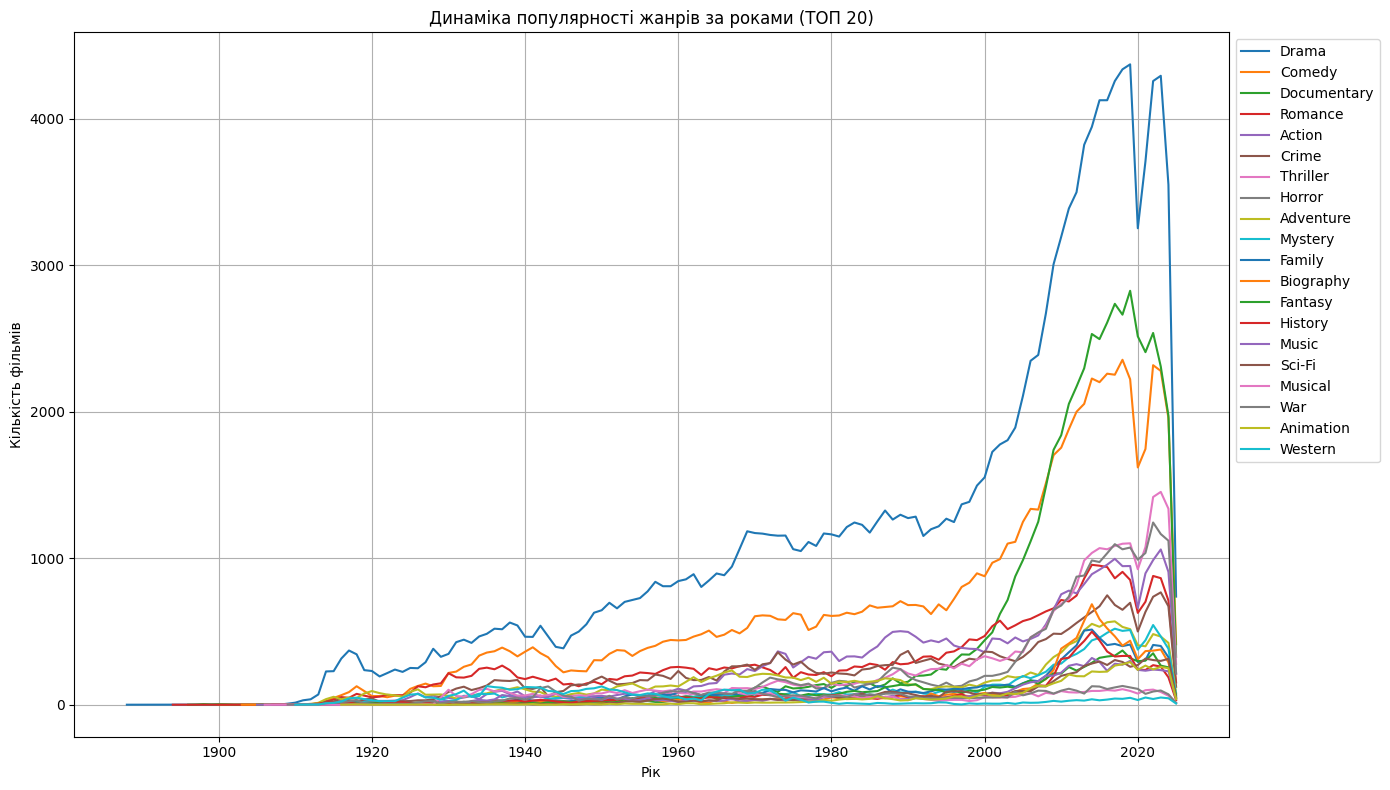

Results for: None
+---------------------+-----------+------------------+----+--------+
|director             |movie_count|avg_rating        |rank|role    |
+---------------------+-----------+------------------+----+--------+
|Christopher Nolan    |12         |8.166666666666668 |1   |director|
|Satyajit Ray         |28         |7.932142857142858 |2   |director|
|Hayao Miyazaki       |12         |7.925000000000001 |3   |director|
|Ertem Egilmez        |21         |7.89047619047619  |4   |director|
|Quentin Tarantino    |15         |7.773333333333334 |5   |director|
|Stanley Kubrick      |13         |7.730769230769231 |6   |director|
|Charles Chaplin      |13         |7.723076923076922 |7   |director|
|Peter Jackson        |15         |7.7               |8   |director|
|Nandita Roy          |10         |7.660000000000001 |9   |director|
|Shiboprosad Mukherjee|10         |7.660000000000001 |9   |director|
|Hrishikesh Mukherjee |11         |7.645454545454546 |10  |director|
|Eldar Ryazanov 

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt


def export_result(df: DataFrame, result_path: str, show_rows: int = 20, title: str = None,
                  partition_column: str = None, num_partitions: int = None) -> None:
    print(f"Results for: {title}")
    df.show(show_rows, truncate=False)
    total_records = df.count()
    print(f"Total number of records in the result: {total_records}")

    for col_name, col_type in df.dtypes:
        if col_type.startswith("array"):
            df = df.withColumn(col_name, F.concat_ws(", ", F.col(col_name)))

    writer = df.write.option("header", "true")

    if partition_column and partition_column in df.columns:
        print(f"Exporting results with partitioning by column: {partition_column}")
        writer.partitionBy(partition_column).csv(result_path, mode="overwrite")
    elif num_partitions and num_partitions > 0:
        print(f"Exporting results with {num_partitions} partitions")
        df.repartition(num_partitions).write.option("header", "true").csv(result_path, mode="overwrite")
    else:
        target_size_mb = 128
        estimated_size_bytes = total_records * len(df.columns) * 100
        estimated_size_mb = estimated_size_bytes / (1024 * 1024)
        optimal_partitions = max(1, int(estimated_size_mb / target_size_mb))

        print(f"Exporting results with automatically determined {optimal_partitions} partitions")
        df.repartition(optimal_partitions).write.option("header", "true").csv(result_path, mode="overwrite")


def most_popular_genres_by_region(
        movie_basics: DataFrame,
        akas: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    filtered_basics = movie_basics.filter(
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    basics_with_ratings = filtered_basics.join(
        ratings,
        "tconst",
        "inner"
    )

    region_data = akas.filter(F.col("region").isNotNull())

    pre_join_df = basics_with_ratings.join(
        region_data,
        basics_with_ratings.tconst == region_data.titleId,
        "inner"
    ).drop(region_data.titleId)

    exploded_df = pre_join_df.withColumn("genre", F.explode("genres"))

    filtered_df = exploded_df.filter(F.col("genre").isNotNull())

    filtered_df = filtered_df.persist()

    agg_df = filtered_df.groupBy("region", "genre").agg(
        F.countDistinct(filtered_basics.tconst).alias("title_count"),
        F.avg("averageRating").alias("avg_rating")
    )

    window_spec = Window.partitionBy("region").orderBy(F.desc("title_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("region", "rank")

    filtered_df.unpersist()

    export_result(ranked_df, os.path.join(results_dir, "most_popular_genres_by_region"))


def yearly_genre_trend_analysis_with_plot(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    # 1. Фільтрація та об'єднання даних
    filtered_basics = movie_basics.filter(
        F.col("startYear").isNotNull() &
        F.col("genres").isNotNull() &
        (F.size("genres") > 0)
    )

    filtered_ratings = ratings.filter(
        F.col("averageRating").isNotNull()
    ).select("tconst", "averageRating", "numVotes")

    join_df = filtered_basics.join(filtered_ratings, "tconst", "inner").persist()

    # 2. Розкладання жанрів
    exploded_df = join_df.withColumn("genre", F.explode("genres"))

    # 3. Агрегація
    agg_df = exploded_df.groupBy("startYear", "genre").agg(
        F.count("*").alias("movie_count"),
        F.avg("averageRating").alias("avg_rating"),
        F.avg("numVotes").alias("avg_votes")
    )

    # 4. Ранжування по роках (не обов'язково для графіка, але залишено)
    window_spec = Window.partitionBy("startYear").orderBy(F.desc("movie_count"))
    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy(F.desc("startYear"), "rank")

    join_df.unpersist()

    # 5. Зберегти у CSV
    output_path = os.path.join(results_dir, "yearly_genre_trend_analysis.csv")
    ranked_df.toPandas().to_csv(output_path, index=False)

    # 6. Зчитати CSV у Pandas
    df = pd.read_csv(output_path)

    # 7. Побудова графіку динаміки популярності по ТОП-20 жанрах
    top_20_genres = df.groupby("genre")["movie_count"].sum().sort_values(ascending=False).head(20).index
    filtered = df[df["genre"].isin(top_20_genres)]

    plt.figure(figsize=(14, 8))
    for genre in top_20_genres:
        genre_data = filtered[filtered["genre"] == genre].sort_values("startYear")
        plt.plot(genre_data["startYear"], genre_data["movie_count"], label=genre)

    plt.title("Динаміка популярності жанрів за роками (ТОП 20)")
    plt.xlabel("Рік")
    plt.ylabel("Кількість фільмів")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def most_successful_directors(
        movie_basics: DataFrame,
        crew: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10) -> None:

    directors_df = (crew.filter(F.col("directors").isNotNull())
                    .join(movie_basics.select("tconst"), "tconst", "inner")
                    .withColumn("director_id", F.explode("directors"))
                    .join(ratings, "tconst", "inner")
                    .filter((F.col("numVotes") >= min_votes) & F.col("averageRating").isNotNull())
                    .join(name_df.select("nconst", "primaryName"),
                          F.col("director_id") == F.col("nconst"), "left")
                    .select("tconst", F.col("primaryName").alias("director"), "averageRating", "numVotes"))

    directors_agg = (directors_df.groupBy("director")
                     .agg(
                         F.count("*").alias("movie_count"),
                         F.avg("averageRating").alias("avg_rating")
                     )
                     .filter(F.col("movie_count") >= min_movies))

    window_spec_dir = Window.orderBy(F.desc("avg_rating"))

    directors_ranked = (directors_agg.withColumn("rank", F.dense_rank().over(window_spec_dir))
                        .withColumn("role", F.lit("director"))
                        .orderBy("rank"))

    export_result(directors_ranked, os.path.join(results_dir, "most_successful_directors"))


def top_actors_by_genre(
        movie_basics: DataFrame,
        principals: DataFrame,
        ratings: DataFrame,
        name_df: DataFrame,
        results_dir: str,
        min_votes: int = 1000,
        min_movies: int = 10,
        high_rating_threshold: float = 7) -> None:

    movies_with_ratings = (movie_basics.join(ratings, "tconst", "inner")
                           .filter(
                               F.col("startYear").isNotNull() &
                               F.col("averageRating").isNotNull() &
                               F.col("genres").isNotNull() &
                               (F.col("numVotes") >= min_votes)
                           )
                           .withColumn("genre", F.explode("genres"))
                           )

    actors_df = (principals.filter(F.col("category").isin("actor", "actress"))
                 .join(movies_with_ratings, "tconst", "inner"))

    actors_with_name = actors_df.join(name_df, "nconst", "inner")

    high_rated_movies = actors_with_name.filter(F.col("averageRating") >= high_rating_threshold)

    actor_movie_count = (actors_with_name.groupBy("primaryName")
                         .agg(F.count("*").alias("movie_count"))
                         .filter(F.col("movie_count") >= min_movies))

    high_rated_movies_filtered = high_rated_movies.join(actor_movie_count, "primaryName", "inner")

    agg_df = high_rated_movies_filtered.groupBy("genre", "primaryName").agg(
        F.count("*").alias("high_rated_movie_count")
    )

    window_spec = Window.partitionBy("genre").orderBy(F.desc("high_rated_movie_count"))

    ranked_df = agg_df.withColumn("rank", F.dense_rank().over(window_spec)) \
                      .orderBy("genre", "rank")

    export_result(ranked_df, os.path.join(results_dir, "top_actors_by_genre"))


def most_successful_genre_combinations(
        movie_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str) -> None:

    basics_filtered = movie_basics.filter(F.col("genres").isNotNull() & (F.size("genres") > 1))

    basics_sorted = (basics_filtered
                     .withColumn("sorted_genres", F.array_sort("genres"))
                     .withColumn("genre_combo", F.concat_ws(", ", F.col("sorted_genres"))))

    joined = (basics_sorted
              .join(ratings, "tconst", "inner")
              .filter((F.col("averageRating").isNotNull())))

    agg_df = (joined.groupBy("genre_combo")
              .agg(
                  F.count("*").alias("movie_count"),
                  F.avg("averageRating").alias("avg_rating"),
                  F.max("startYear").alias("latest_year")
              )
              .orderBy(F.desc("latest_year"), F.desc("movie_count"), F.desc("avg_rating")))

    export_result(agg_df, os.path.join(results_dir, "most_successful_genre_combinations"))


def top_directors_by_genre(
        movie_basics: DataFrame,
        principals: DataFrame,
        name_basics: DataFrame,
        ratings: DataFrame,
        results_dir: str,
        min_votes: int = 1000) -> None:

    movies = movie_basics.filter(
        (F.col("titleType") == "movie") & F.col("genres").isNotNull()
    ).select("tconst", "genres")

    movies_with_ratings = movies.join(ratings, "tconst", "inner") \
                                .filter(F.col("numVotes") >= min_votes) \
                                .select("tconst", "genres", "averageRating")

    directors = principals.filter(F.col("category") == "director") \
                          .select("tconst", "nconst")

    movies_with_directors = movies_with_ratings.join(
        directors, "tconst", "inner"
    ).join(
        name_basics.withColumnRenamed("primaryName", "director_name"),
        "nconst",
        "inner"
    ).select(
        "tconst", "genres", "director_name", "averageRating"
    )

    exploded_genres = movies_with_directors.withColumn("genre", F.explode(F.col("genres")))

    director_genre_stats = exploded_genres.groupBy("genre", "director_name").agg(
        F.avg("averageRating").alias("avg_rating"),
        F.count("*").alias("movie_count")
    ).filter(F.col("movie_count") >= 10)

    window_spec = Window.partitionBy("genre").orderBy(F.desc("avg_rating"), F.desc("movie_count"))
    ranked_directors = director_genre_stats.withColumn("rank", F.row_number().over(window_spec))

    top_directors_by_genre = ranked_directors.filter(F.col("rank") <= 5).orderBy("genre", "rank")

    export_result(top_directors_by_genre, os.path.join(results_dir, "top_directors_by_genre"))


def main(dataframes: dict, results_dir: str = "results") -> None:
    os.makedirs(results_dir, exist_ok=True)

    basics = dataframes["basics"]
    akas = dataframes["akas"]
    crew = dataframes["crew"]
    ratings = dataframes["ratings"]
    principals = dataframes["principals"]
    name_df = dataframes["name"]

    movie_basics = basics.filter(F.col("titleType") == "movie")

    top_directors_by_genre(movie_basics, principals, name_df, ratings, results_dir)
    most_popular_genres_by_region(movie_basics, akas, ratings, results_dir)
    yearly_genre_trend_analysis_with_plot(movie_basics, ratings, results_dir)
    most_successful_directors(movie_basics, crew, ratings, name_df, results_dir)
    top_actors_by_genre(movie_basics, principals, ratings, name_df, results_dir)
    most_successful_genre_combinations(movie_basics, ratings, results_dir)


main(dataframes, results_dir="results")